
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   405450

Total number of variables............................:      900
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

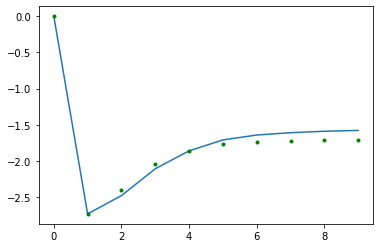

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 15 12:02:47 2020

@author: sanja
"""


from casadi import *
import picos as pic
import cvxopt as cvx
import numpy as np
from scipy import signal
import numpy.linalg as la
import scipy
from scipy.linalg import block_diag
from control.matlab import *
import matplotlib.pyplot as plt


# Function to compute R inverse
def Rinv(v):
    r = v.T @ la.pinv(v @ v.T);
    return r


# State Matrices of the system to be identified
A = np.array([[-0.4,-0.1,-0.2],[-0.6, -.8, -0.5],[-0.2,-0.5, -1.2]])
B = np.array([[-1.6],[0.3],[-1.1]])
C = np.array([1.4,-0.8,0.5])
D = 0.2;

n = len(A)

# Define the system
t = np.linspace(0, 10,10)   
u = np.ones_like(t)
sys = ss(A,B,C,D)
n = 15;
sys = rss(n)
y, tout, x = lsim(sys, u, t)
plt.plot(y)

# Construct relevant matrices 
X1_til = x[:-1,:].T;
X2_til = x[1:,:].T;
U1 = u[:-1];
XU =  Rinv(np.vstack((X1_til,U1)));
X = X2_til @ XU; 
X1 = X[:n,:n]
X22 = X[:,n:]
B_opt = X22;

# Weighting matrices in the cost:
X1 = np.hstack((X1,np.zeros((n,n))))
X2 = np.vstack((np.eye(n),np.zeros((n,n))))
X3 =  X2.T
X4 = np.hstack((np.zeros((n,n)),np.eye(n))).T;

# The optimization problem: 
nrow = 2*n;
ncol = 2*n;
U = SX.sym('x',nrow,ncol); 
V = U @ U.T;
x = reshape(U,nrow*ncol,1);
nlp = {'x':x, 'f':(trace(( X1 @ V @ X2  - X3 @ V @ X4).T @ (X1 @ V @ X2  - X3 @ V @ X4)))**2 , 'g':[]}
S = nlpsol('S', 'ipopt', nlp)
r = S(x0= np.random.rand(nrow*ncol,))
x_opt = r['x']

# Get back required matrices:
U_opt = reshape(x_opt,nrow,ncol);
V_opt = U_opt @ U_opt.T;
P_opt = V_opt[0:n,0:n]
Q_opt = V_opt[0:n,n:]
A_opt = Q_opt @ la.inv(P_opt)

# The output equation:
Rx = XU @ block_diag(P_opt, 1); 
Y = y[:-1].T @ Rx @ Rinv(np.vstack((X1_til,U1)) @ Rx);
C_opt = Y[:n];
D_opt = Y[n:];

# We now have all the state matrices, can construct the system and simulate
dt = tout[1] - tout[0]
sys_id_d = ss(A_opt, B_opt,C_opt, D_opt, dt )
sys_id_c = c2d(sys,dt)
y_id, tout, x_id = lsim(sys_id_d, u, t)
plt.plot(y_id, 'g.')
